<h5 align = "center">Ronan Byrne
13368681 </h5>

# Algorithmic Bias - Core Code
Some code to get started on the Algorithmic Bias assignment.   
The dataset is Haberman's Survival Data Set from the UCI ML repository.  

<br>
<h1 style="color:blue;" align = "center"> Introduction </h1>
<br>

Bias is obviously quite an issue when it comes to many of the classification problems that face the modern day data scientist. Take for example the classic problem of the prediction of credit card fraud. Obviously if we study 500 different credit card transactions the vast majority of these, say 495, will be legitimate transactions whilst perhaps 5 will not. Thus, it is easy to see how a classifier created which such data would have a tendency to predict legit transactions. 

Before we dive into the analysis of our data set it is also worth noting that for an exercise such as this bias can be viewed independent from accuracy. Accuracy with a biased classifier will often come from the repetive and blind prediction of the majority class in the training data which is likely to be the majority class in the test set of the data. 

Finally, when searching for bias in a classification problem it is likely to show up as a distortion between the total number of predicted positives(both true and false) and the total number of positives in the dataset. This distortion can be measured by the following formula:

($TP$ + $FP$)  / ($TP$ + $FN$)

This is known as the US score and a score of less than 1 indicates a bias away from the positive class (Cunningham & Delaney, 2020).



In [1]:
import numpy as np
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score
from matplotlib import pyplot
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier
import mglearn
import matplotlib
import matplotlib.pyplot as plt
import numpy as np



surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
surv.head()

,Age,Year,NNodes,Class,Survived
0,30,64,1,1,GE5
1,30,62,3,1,GE5
2,30,65,0,1,GE5
3,31,59,2,1,GE5
4,31,65,4,1,GE5


In [2]:
surv['Survived'].value_counts() 

GE5    225
L5      81
Name: Survived, dtype: int64

In [3]:
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X.shape, y.shape

((306, 3), (306,))

In [4]:
print("Minority class : %0.2f" % (Counter(y)['L5']/len(y)))

Minority class : 0.26


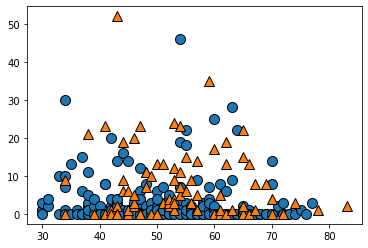

In [5]:
model = KNeighborsClassifier(n_neighbors=3)
clf = model.fit(X,y)
mglearn.discrete_scatter(X[:,0], X[:,2], y, ax=None)

The two graph above gives us some idea of what to expect when we begin looking at the effects of bias on various different classifiers. 

Here we are simply doing a quick check of the dispertion of the classes based on the two features age and NNodes. 

Although this is by no means complete it does give us a rough idea of how our classifiers may perform in terms of bias. We can see that there is no major distinction between the two classes. This will likely make it very hard for $k$NN and logistic regression to perform well. These will both likely have a strong bias towards the majority class as they will not have any clear way to make a distinction between classes as they are so tightly grouped. 

The performance of decision tree and gradient boosting classifiers is anyones guess at this point.

<br>
<h1 style="color:blue;" align = "center"> Part 1 (A): Hold Out Bias </h1>
<br>

## $k$-NN
L5 is the minority class at ~26%.  
$k$-NN classifier picks up this under-representation and accentuates it,  
predicting just 16% L5. 

In [6]:
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.model_selection import train_test_split

kNN = KNeighborsClassifier(n_neighbors=3)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/2, random_state=42)
y_pred = kNN.fit(X_train, y_train).predict(X_test)
print(X_train.shape,X_test.shape)
print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))

pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']

print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

(153, 3) (153, 3)
Accuracy:  0.77
Minority class in test set : 0.24
Predicted minority class : 0.16


In [7]:
Counter(y_pred)

Counter({'GE5': 128, 'L5': 25})

In [8]:
Counter(y_test)

Counter({'GE5': 117, 'L5': 36})

In [9]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f} \n".format(acc)) 
print("[TN, FP]")
print("[FN, TP]")
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
kNNUS = (confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])
print("US Score: {:.2f} ".format(kNNUS))

Accuracy: 0.77 

[TN, FP]
[FN, TP]
Confusion matrix:
[[105  12]
 [ 23  13]]

US Score: 0.69 


The confusion matrix above indicates that the $k$NN classifier in it's current form, using 3 nearest neighbours, is biased towards the majority class (GE5). The classifier has made a total of 153 predictions and of these only 25 where predicted as positive. This equates to only predicting the minority class about 16% of the time. We can see that the false negative rate is about 15% meaning that these additional 15% should have been classified as positive. This is a precision issue, and for the case of analysing bias we are not too concerned, but it is still worth noting.

Finally, in terms of the US score a strong bias away from the positive class can seen with a score of 0.7. Remember, a score below 1 indicates a bias away from the positive.

In [10]:
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

         GE5       0.82      0.90      0.86       117
          L5       0.52      0.36      0.43        36

    accuracy                           0.77       153
   macro avg       0.67      0.63      0.64       153
weighted avg       0.75      0.77      0.76       153



The classification report above further cements the findings that the current classifier is biased towards the majority class. We can see that recall is extremely low at 36%. This effectively means that only 36% of the possible positive classifications are being predicted. This is in contrast to that of the majority class (GE5) where 90% of the majority class is being predicted. We can also why this bias may be occuring as even in our test data GE5 has a strong majority of 117:36. Even when this split is taken into account the weighted avergae for recall, which calculates the recall of the positive class with weight taken into account, is still quite low at 77%.

## Decision Trees

In [11]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(X_train.shape,X_test.shape)
pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']
print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

(153, 3) (153, 3)
Accuracy:  0.66
Minority class in test set : 0.24
Predicted minority class : 0.26


Here we begin to examine the Decision-Tree Classifier using the same hold out (train-test split) data as with the kNN classifier. Thus, the only difference here is the classifier that is being used. 

The decision tree classifier is not as biased towards the majority class as the kNN classifier above. It is, however, providing a low accuracy score as it may be overfitting to the minority class slightly. This can be seen by the fact that it predicted 26% in the way of the minority class but this was only represented by 24% of the pieces of sample data.

However, due to the fact that the tree is $unpruned$, it can likely be improved as it may currently be "not generalizing well to new data" (Müller & Guido, 2017).

In [12]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f} \n".format(acc)) 
print("[TN, FP]")
print("[FN, TP]")
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
dtUS = (confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])
print("US Score: {:.2f} ".format(dtUS))

Accuracy: 0.66 

[TN, FP]
[FN, TP]
Confusion matrix:
[[89 28]
 [24 12]]

US Score: 1.11 


When we calculate the US score we can see that the bias towards the majority class does not exist here. We obtain a score of 1.1 indicating that we are in fact leaning in the favour of the minority class very slightly. 

In [13]:
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 

Report:
              precision    recall  f1-score   support

         GE5       0.79      0.76      0.77       117
          L5       0.30      0.33      0.32        36

    accuracy                           0.66       153
   macro avg       0.54      0.55      0.54       153
weighted avg       0.67      0.66      0.67       153



The recall of both the GE5 and L5 classes have fallen here when compared to the kNN classifier. This indicates that this is simply not a good classifier. It is also worth noting that the f1 score for both classes, which takes precision into account, also performs quite badly. This ultimately indicates a bad classifier and may well be likely due to a lack of pruning. But, nonetheless, the effect of bias are not present here.

## Logistic Regression

In [14]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
print(X_train.shape,X_test.shape)
pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']
print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

(153, 3) (153, 3)
Accuracy:  0.78
Minority class in test set : 0.24
Predicted minority class : 0.07


This logistic regression classifier sees an obvious increse in accuracy but this is likely due to the fact that it is simply predicting the majority class. 
This can be seen by the massive reluctance that it has with predicting the minority class (only .7% predicted vs 24% represented). 

In [15]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
print("[TN, FP]")
print("[FN, TP]")
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
lrUS = (confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])
print("US Score: {:.2f} ".format(lrUS))

Accuracy: 0.78

[TN, FP]
[FN, TP]
Confusion matrix:
[[113   4]
 [ 30   6]]

US Score: 0.28 


The US score leaves much to be desired here at only 0.28. This indicates a very strong bias away from our positive minority class.

In [16]:
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report))

Report:
              precision    recall  f1-score   support

         GE5       0.79      0.97      0.87       117
          L5       0.60      0.17      0.26        36

    accuracy                           0.78       153
   macro avg       0.70      0.57      0.57       153
weighted avg       0.75      0.78      0.73       153



Both the confusion matrix and classification point to obvious bias towards the majority class. 

The classification report shows that recall is more or less terrible for the minority class. However, it is very high for the majority class. This explains the increase in accuracy seen with this classifier...it is simply predicting the majority class which has led to increased accuracy but worse generalisation to unseen data. This can also been seen by the 0.79 precision score of the majority class which indicates that the classifier is simply predicting the majority class and many times this incorrect but it makes the prediction due to a bias.

## Gradient Boosting

In [17]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
print(X_train.shape,X_test.shape)
pred_neg = Counter(y_pred)['L5']
test_neg = Counter(y_test)['L5']
print('Accuracy:  %0.2f' % accuracy_score(y_pred, y_test))
print("Minority class in test set : %0.2f" % (test_neg/len(y_test)))
print("Predicted minority class : %0.2f" % (pred_neg/len(y_pred)))

(153, 3) (153, 3)
Accuracy:  0.70
Minority class in test set : 0.24
Predicted minority class : 0.24


Gradient boosting is an ensemble classifier that uses decision trees meaning that it creates many different tress and uses a voting system to come up with predictions. Thus it makes sense that we see similar, albeit better, results to the results seen with the decision tree classifier.

In [18]:
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
print("[TN, FP]")
print("[FN, TP]")
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
gbUS = (confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])
print("US Score: {:.2f} ".format(gbUS))

Accuracy: 0.70

[TN, FP]
[FN, TP]
Confusion matrix:
[[94 23]
 [23 13]]

US Score: 1.00 


The US score of this classifier is much like that of the similar decision tree classifier with an overall score of 1 as oppossed 1.1. This would indicate that there is essentially no bias at play here.

In [19]:
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report))

Report:
              precision    recall  f1-score   support

         GE5       0.80      0.80      0.80       117
          L5       0.36      0.36      0.36        36

    accuracy                           0.70       153
   macro avg       0.58      0.58      0.58       153
weighted avg       0.70      0.70      0.70       153



Like the decision tree, this classifier is just generally bad. Predictions of the minority class do occur but when they occur they are not very precise, being incorrect almost 2/3 of the time. Therefore we can say that bias is not massively an issue here but instead the issue is simply a bad classifier. 

<br>
<h3 style="color:blue;" align = "center"> Visualising Bias </h3>
<br>

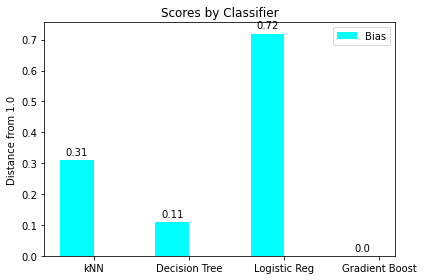

In [20]:
labels = ['kNN', 'Decision Tree', 'Logistic Reg', 'Gradient Boost']
before_scores = [.31, .11, .72, 0]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_scores, width, label='Bias', color="cyan")

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distance from 1.0')
ax.set_title('Scores by Classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)

fig.tight_layout()

plt.show()

The above graph simply shows the US score for each classifier. It does not take into account the direction of bias and instead just attempts to show which classifiers are worst effected by bias. 

As predicted at the bgeinning of this notebook, both $k$NN and logistic regression are the worst effected and this is most likely due to the fact that there is no major distiunction between the classes and so the two mentioned classifoers are relying on bias to make predictions. 

<br>
<h1 style="color:blue;" align = "center"> Part 1 (B): Cross Val Bias </h1>
<br>

In [21]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer
def tp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 1]
def tn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 0]
def fp(y_true, y_pred): return confusion_matrix(y_true, y_pred)[0, 1]
def fn(y_true, y_pred): return confusion_matrix(y_true, y_pred)[1, 0]
scoring = {'tp' : make_scorer(tp), 'tn' : make_scorer(tn),
           'fp' : make_scorer(fp), 'fn' : make_scorer(fn)}

models = [kNN,tree,logreg,gbrt]

folds = 10
v = 0 #  use 1 or 0

In [22]:
for m in models:
    cv_results = cross_validate(m, X, y, cv= folds,scoring=scoring, return_train_score=False, 
                                    verbose = v, n_jobs = -1)
    fp_rate = cv_results['test_fp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
    tp_rate = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    recall = cv_results['test_tp'].sum()/(cv_results['test_tp'].sum()+cv_results['test_fn'].sum())
    precision = cv_results['test_tp'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tp'].sum())
  
    print("{} x CV {:22} FP: {:.2f}   TP: {:.2f}    RECALL: {:.2f}    PRECISION: {:.2f}".format(folds, type(m).__name__, fp_rate, tp_rate, recall, precision)) 

10 x CV KNeighborsClassifier   FP: 0.20   TP: 0.31    RECALL: 0.31    PRECISION: 0.36
10 x CV DecisionTreeClassifier FP: 0.31   TP: 0.35    RECALL: 0.35    PRECISION: 0.29
10 x CV LogisticRegression     FP: 0.04   TP: 0.16    RECALL: 0.16    PRECISION: 0.57
10 x CV GradientBoostingClassifier FP: 0.25   TP: 0.25    RECALL: 0.25    PRECISION: 0.26


We can see that for each of the above classifiers false positive rates continued to remain low. The true positive rate does not do much better.

The recall for all models actually became worse, except in the case of the decision tree classifier which experienced a very slight increase. 

For the sake of arguement we can compare the false positive and true positive rates with their negative counterparts.

In [23]:
for m in models:
    cv_results = cross_validate(m, X, y, cv= folds,scoring=scoring, return_train_score=False, 
                                    verbose = v, n_jobs = -1)
    fn_rate = cv_results['test_fn'].sum()/(cv_results['test_fn'].sum()+cv_results['test_tp'].sum())
    tn_rate = cv_results['test_tn'].sum()/(cv_results['test_fp'].sum()+cv_results['test_tn'].sum())
  
    print("{} x CV {:22} FN: {:.2f}   TN: {:.2f}".format(folds, type(m).__name__, fn_rate, tn_rate)) 

10 x CV KNeighborsClassifier   FN: 0.69   TN: 0.80
10 x CV DecisionTreeClassifier FN: 0.65   TN: 0.69
10 x CV LogisticRegression     FN: 0.84   TN: 0.96
10 x CV GradientBoostingClassifier FN: 0.75   TN: 0.75


In all cases the sensitivity, or false negative rate, is vastly higher then the false positive rates. This indicates that the classifiers are overfitting to the majority class and are less likely and willing to predict the positive minority class. A similar result can be seen with the true negative rate.

Thus, in conclusion to this section, we can say that bias that obviously exists, in terms of L5 being under represented, effects each classifier differently. For both $k$NN and logistic regression the effects are quite obvious and make the classifiers, in their current form, quite useless. The decision tree classifiers and the gradient boosting classifier are not effected by the bias in terms of their US score (their ability to predict positives) but they are still very inaccurate in their current form.

<br>
<h1 style="color:blue;" align = "center"> Part 2 (A): Tackling Bias - SMOTE </h1>
<br>

SMOTE is essentially a form of oversampling. This basically helps to tackle bias by upsampling the minority class of the data set.

In [24]:
# example of oversampling the minority class
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE

In [25]:
surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/2, random_state=42)

In [26]:
unique, count = np.unique(y_train, return_counts=True)
pre_smote_counts = {k:v for (k,v) in zip(unique, count)}
print(pre_smote_counts)

{'GE5': 108, 'L5': 45}


In [27]:
sm = SMOTE(random_state=12)

In [28]:
X_train, y_train = sm.fit_sample(X_train, y_train)

In [29]:
unique, count = np.unique(y_train, return_counts=True)
y_train_smote_value_count = { k:v for (k,v) in zip(unique, count)}
y_train_smote_value_count

{'GE5': 108, 'L5': 108}

We can clearly see how SMOTE has worked here. Previously our training set was split GE5 = 108, L5 = 45. After we applied SMOTE we have made the two classes equal in terms of appearnaces in the dataset by increasing the minority, L5, set. Therefore we now have GE5 = 108, L5 = 108.

In [30]:
print("---------------------------------KNN------------------------------------")
y_pred = kNN.fit(X_train, y_train).predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
print("[TN, FP]")
print("[FN, TP]")
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(kNNUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 
print("---------------------------------DECISION TREE------------------------------------")
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(dtUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 
print("\n")
print("---------------------------------Logistic Regression------------------------------------")
logreg = LogisticRegression().fit(X_train, y_train)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(lrUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report))
print("\n")
print("---------------------------------Gradient Boosting------------------------------------")
gbrt = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbrt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(gbUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report))

---------------------------------KNN------------------------------------
Accuracy: 0.63

[TN, FP]
[FN, TP]
Confusion matrix:
[[80 37]
 [19 17]]

US Score: 1.50
Original US: 0.69

Report:
              precision    recall  f1-score   support

         GE5       0.81      0.68      0.74       117
          L5       0.31      0.47      0.38        36

    accuracy                           0.63       153
   macro avg       0.56      0.58      0.56       153
weighted avg       0.69      0.63      0.66       153

---------------------------------DECISION TREE------------------------------------
Accuracy: 0.62

Confusion matrix:
[[80 37]
 [21 15]]

US Score: 1.44
Original US: 1.11

Report:
              precision    recall  f1-score   support

         GE5       0.79      0.68      0.73       117
          L5       0.29      0.42      0.34        36

    accuracy                           0.62       153
   macro avg       0.54      0.55      0.54       153
weighted avg       0.67      0.62  

From the above results, it seems that SMOTE has worked a little bit too well. It is clear that SMOTE has tackled the bias towards the majority class (GE5) but it has now made each of our classifiers bias towards L5. This can be seen due to the fact that each of the US scores for each of the classifiers is now above 1, in most cases by quite a large amount.  

The overall accuracy of the classifier has fallen. This is likely due to the fact that the positive class is now being predicted more often, although these predictions are not always correct. These incorrect predictions obviously reduce the accuracy as in many cases these would have been correctly predicting the majority class simply out of bias.

These findings do not indicate that the classifiers are good classifiers but they certainly indicate that the classifiers are not as effected by bias towards GE5 as they were previously.

The long and tedious set of results above basically help to further prove the point that was discussed after analysing the results from the US Scores.

Essentially, in all, cases bias has been greatly decreased. All classifiers now have a greater tendency predict the previously minority class. 

On our test data this has resulted, in all cases, in a decrease in accuracy. Once again, this is due to the fact that the classifiers are not just blindly predicting the majority class. Both overall accuracy and f1-score have suffered. 

In all case the number of false positives are quite high, especially when compared with the number of false negatives. Thus, perhaps with some tuning, or perhaps with slightly less L5's in our training set we could increase the accuracy of these classifiers whilst also maintaining the reduced bias.

<br>
<h1 style="color:blue;" align = "center"> Part 2 (B): Tackling Bias - Alternative Method (TomekLinks)</h1>
<br>

Obviously there was some issue with oversampling using SMOTE. One alternative would be the use of undersampling but obviously this is undesirable as we may lose some pretty important data if we do this. 

One form of undersampling that is noteable is the use of Tomek links. These are links of pairs of closely related instances but of the opposite classes. For each of these pairs the majority class will be removed. This will increase the space between the two classes and this should halp our classifier to be better able to distinguish between the two classes. This means that, although some data will be dropped, the majority of the data will be preserved.

The idea is captured well by the below image (Alencar, 2017):

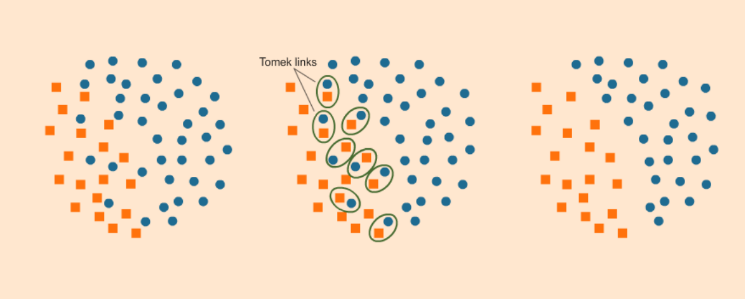

In [31]:
#Need to read in the file and split again to get rid of effects of SMOTE

surv = pd.read_csv('survival.csv')
surv['Survived'] = 'GE5'
surv.loc[surv['Class']==2,'Survived']='L5'
y = surv.pop('Survived').values
surv.pop('Class')
X = surv.values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 1/2, random_state=42)
unique, count = np.unique(y_train, return_counts=True)
counts = {k:v for (k,v) in zip(unique, count)}
print(counts)

{'GE5': 108, 'L5': 45}


In [32]:
from imblearn.under_sampling import TomekLinks
tl = TomekLinks()

In [33]:
X_train_tl, y_train_tl = tl.fit_sample(X_train, y_train)
unique, count = np.unique(y_train_tl, return_counts=True)
counts = {k:v for (k,v) in zip(unique, count)}
print(counts)

{'GE5': 91, 'L5': 45}


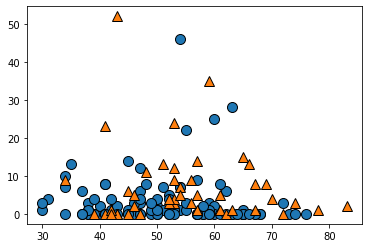

In [34]:
model = KNeighborsClassifier(n_neighbors=3)
clf = model.fit(X_train,y_train)
mglearn.discrete_scatter(X_train[:,0], X_train[:,2], y_train, ax=None)

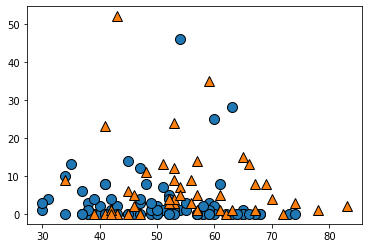

In [35]:
model = KNeighborsClassifier(n_neighbors=3)
clf = model.fit(X_train_tl,y_train_tl)
mglearn.discrete_scatter(X_train_tl[:,0], X_train_tl[:,2], y_train_tl, ax=None)

From the two graphs above we can see how Tomek Links worked on our data.  Tomek Links has reduced the number of GE5 data samples from 108 to 91 whilst maintaining L5 at 45. If we compare the two graphs we can see that the samples of GE5 that were dropped are those that are closely linked to the samples of L5. For example, the sample of L5 (the orange triangle) at the very center is now alone when before it was closely linked to a GE5 sample. The two triangles just above hte 70 on the x axis have also been relieved of a close GE5. There are in total 17 cases of this but this is not massively obvious as many of the dropped GE5 samples may be forom the bottom area of the graph where it is difficult to see due to the density of samples in that region.

Ultimately, however, this should make it easier for both $k$NN and LR to perform better in terms of bias.

In [36]:
print("---------------------------------kNN------------------------------------")
y_pred = kNN.fit(X_train_tl, y_train_tl).predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(kNNUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 
print("\n")
print("---------------------------------Logistic Regression------------------------------------")
logreg = LogisticRegression().fit(X_train_tl, y_train_tl)
y_pred = logreg.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(lrUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report))
print("\n")
print("---------------------------------DECISION TREE------------------------------------")
tree.fit(X_train_tl, y_train_tl)
y_pred = tree.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(dtUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 
print("\n")
print("---------------------------------Gradient Boosting------------------------------------")
gbrt = GradientBoostingClassifier().fit(X_train_tl, y_train_tl)
y_pred = gbrt.predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: {:.2f}\n".format(gbUS))
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report))

---------------------------------kNN------------------------------------
Accuracy: 0.75

Confusion matrix:
[[100  17]
 [ 22  14]]

US Score: 0.86
Original US: 0.69

Report:
              precision    recall  f1-score   support

         GE5       0.82      0.85      0.84       117
          L5       0.45      0.39      0.42        36

    accuracy                           0.75       153
   macro avg       0.64      0.62      0.63       153
weighted avg       0.73      0.75      0.74       153



---------------------------------Logistic Regression------------------------------------
Accuracy: 0.78

Confusion matrix:
[[109   8]
 [ 26  10]]

US Score: 0.50
Original US: 0.28

Report:
              precision    recall  f1-score   support

         GE5       0.81      0.93      0.87       117
          L5       0.56      0.28      0.37        36

    accuracy                           0.78       153
   macro avg       0.68      0.60      0.62       153
weighted avg       0.75      0.78    

The results that we see from the use of tomek links are quite interesting and the technique partly worked.

For both $k$NN and logistic regression the accuracy is quite high in terms of the results that we have been seeing. Before we applied any sort of over or under sampling we saw quite poor US scores. In the case of the logistic regression classifier the US score is still quite low indicating that a bias towards the dominant class is still present. However, the US score for the kNN classifier is actually quite good at 0.86. This indicates that although a bias towards G5 still exists, it is not very prominent. It is also worth noting that the accuracy has more or less been maintained to get this reduction in bias.

Unfortunately the same cannot be said for both of our other classifiers. The US scores in both cases have increased but towards L5. This is likely due to the fact that a bias towards GE5 was not presenty originally for either of these classifiers. Therefore by dropping some samples of GE5 we have increased the bias towards L5. 

Thus, we can say that Tomek Links are a positive addition for our first two classifiers but have a negative effect on the latter two. 

After all this testing the it seems that the best reduction in bias was through the use of Tomek Links with the $k$NN classifier and so we shall now test this on an alternative dataset.

<br>
<h3 style="color:blue;" align = "center"> Visualising Change in Bias </h3>
<br>

In order to fully understand the reductions in bias that we achieved it may be useful to plt the bias levels before and after the techniquues we have used to get a good idea of how 

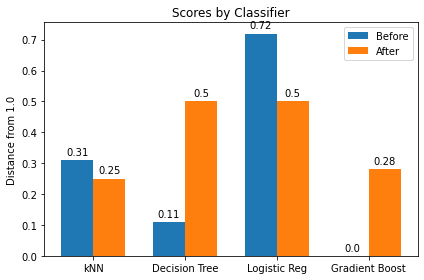

In [37]:
labels = ['kNN', 'Decision Tree', 'Logistic Reg', 'Gradient Boost']
before_scores = [.31, .11, .72, 0]
after_scores = [.25, .5, .5, .28]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, before_scores, width, label='Before')
rects2 = ax.bar(x + width/2, after_scores, width, label='After')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Distance from 1.0')
ax.set_title('Scores by Classifier')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)

fig.tight_layout()

plt.show()

We can see from the above graph roughly how the bias has changed for each inividual classifier. We are hoping that the orange bar will have reduced for each classifier. The numbers above each bar represent the distance the US score is away from 1. The direction of bias does not matter. 

Thus we can see that the classifier that has gained the most is the logistic regression classifier. 

We can also see that both gradient boosting and decision trees have suffered from the change.

Finally, $k$NN has received a resonably good change whilst also having the current lowest amount of bias in terms of US score. Therefore this visualisation can be used as another reason to use $k$NN on an alternative dataset.

<br>
<h1 style="color:blue;" align = "center"> Part 3: Alternative Dataset</h1>
<br>

In [38]:
from sklearn.datasets import load_breast_cancer
bc = load_breast_cancer()

In [39]:
unique, count = np.unique(bc.target, return_counts=True)
counts = {k:v for (k,v) in zip(unique, count)}
print(bc.target_names)
print(counts)
print(bc.data.shape)

['malignant' 'benign']
{0: 212, 1: 357}
(569, 30)


The dataset we are now dealing with is the Wisconsin Breast Cancer Dataset that comes with sci-kit. Our two classes are malignant and benign and it is biased towards the positive class this time. 

The dataset is also rather large in comparison to the data set we just used with 569 entries and 30 features.

In [40]:
X_train, X_test, y_train, y_test = train_test_split(bc.data, bc.target, stratify=bc.target, random_state=42)

In [41]:
unique, count = np.unique(y_train, return_counts=True)
counts = {k:v for (k,v) in zip(unique, count)}
print(bc.target_names)
print(counts)

['malignant' 'benign']
{0: 159, 1: 267}


We must first check to see how a basic decision tree classifier with no pruning works on our data set as it currently is.

In [42]:
kNN = KNeighborsClassifier(n_neighbors=3)

y_pred = kNN.fit(X_train, y_train).predict(X_test)

acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f} \n".format(acc)) 
print("[TN, FP]")
print("[FN, TP]")
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
kNNUS = (confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])
print("US Score: {:.2f} ".format(kNNUS))

Accuracy: 0.93 

[TN, FP]
[FN, TP]
Confusion matrix:
[[47  6]
 [ 4 86]]

US Score: 1.02 


We have now split the data and can see that the bias is still present

In [43]:
X_train_tl, y_train_tl = tl.fit_sample(X_train, y_train)
unique, count = np.unique(y_train_tl, return_counts=True)
counts = {k:v for (k,v) in zip(unique, count)}
print(counts)

{0: 159, 1: 258}


In [44]:
y_pred = kNN.fit(X_train_tl, y_train_tl).predict(X_test)
acc = accuracy_score(y_test, y_pred)
print("Accuracy: {0:.2f}\n".format(acc)) 
confusion = confusion_matrix(y_test, y_pred)
print("Confusion matrix:\n{}\n".format(confusion))
print("US Score: {:.2f}".format((confusion[0][1] + confusion[1][1]) / (confusion[1][0] + confusion[1][1])))
print("Original US: 1.02")
report = classification_report(y_test, y_pred, target_names = ['GE5', 'L5'])
print("Report:\n{}".format(report)) 
print("\n")

Accuracy: 0.92

Confusion matrix:
[[48  5]
 [ 6 84]]

US Score: 0.99
Original US: 1.02
Report:
              precision    recall  f1-score   support

         GE5       0.89      0.91      0.90        53
          L5       0.94      0.93      0.94        90

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143





Obviously there has not been much change in bias (.01) but this is likely due to the fact that there was not much room for improvement. Also, if we look at what the Tomek Links method did in this case it didn't actually do a massive amount. We can see that before we implemented the technique there was 267 pieces of data relating to the majority class and after there was still 258. Thus, only 9 examples have been dropped. This is likely because there was not many points from alternating classes close to each other. 

If we check the positions of the points using the top 2 features of $k$NN we may be able to visualise this.

Feature:0 mean radius, Score: 0.00000
Feature:1 mean texture, Score: 0.00047
Feature:2 mean perimeter, Score: 0.00141
Feature:3 mean area, Score: 0.17418
Feature:4 mean smoothness, Score: 0.00000
Feature:5 mean compactness, Score: 0.00000
Feature:6 mean concavity, Score: 0.00000
Feature:7 mean concave points, Score: 0.00000
Feature:8 mean symmetry, Score: 0.00000
Feature:9 mean fractal dimension, Score: 0.00000
Feature:10 radius error, Score: 0.00000
Feature:11 texture error, Score: 0.00000
Feature:12 perimeter error, Score: 0.00000
Feature:13 area error, Score: -0.00047
Feature:14 smoothness error, Score: 0.00000
Feature:15 compactness error, Score: 0.00000
Feature:16 concavity error, Score: 0.00000
Feature:17 concave points error, Score: 0.00000
Feature:18 symmetry error, Score: 0.00000
Feature:19 fractal dimension error, Score: 0.00000
Feature:20 worst radius, Score: 0.00000
Feature:21 worst texture, Score: 0.00141
Feature:22 worst perimeter, Score: 0.00892
Feature:23 worst area, Sc

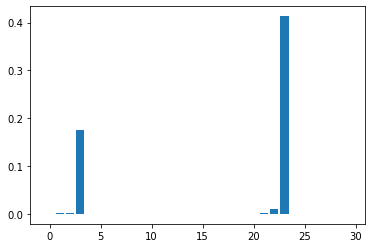

In [45]:
from sklearn.inspection import permutation_importance

#Using training set before Tomek Links
results = permutation_importance(kNN, X_train, y_train, scoring='accuracy')
importance = results.importances_mean
for i,v in enumerate(importance):
    print('Feature:{} {}, Score: {:.5f}'.format(i, bc.feature_names[i],v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

It seems that the two most important features are mean area and worst area.

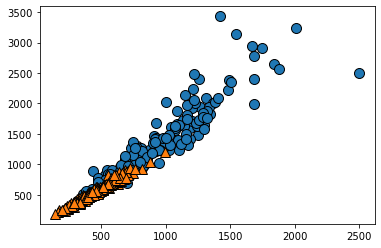

In [46]:
model = KNeighborsClassifier(n_neighbors=3)
clf = model.fit(X_train,y_train)
mglearn.discrete_scatter(X_train[:,3],X_train[:,23], y_train, ax=None)

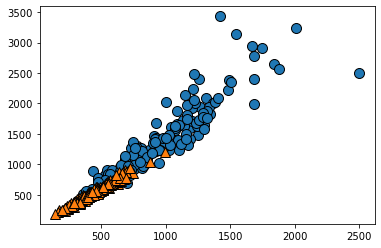

In [47]:
model = KNeighborsClassifier(n_neighbors=3)
clf = model.fit(X_train_tl,y_train_tl)
mglearn.discrete_scatter(X_train_tl[:,3],X_train_tl[:,23], y_train_tl, ax=None)

These graphs are by no means scientific as they onlt take into account 2 features, allbeit the two most important features, of the data set.

We can see from the graphs that the use of Tomek Links did not actually change a massive amount. From looking at the graphs it is next to impossible to see any changes. 

This is due to the fact there was already a clear area of seperation for us to work with. For example, if we draw a line from roughly 3000 on the y-axis down to roughly 1000 on the x-axis we would have relatively clear seperation of the classes. this is what Tomek Links attempt to achieve but in this case this seperation was already present. This was not the case for the first data set we tested.

Thus the use of Tomek Links was actually more or less an extra dditional step that was unnesseccary for this specific data set.

<br>
<h1 style="color:blue;" align = "center"> Conclusion</h1>
<br>

We can now see that bias in our data can effect different classifiers in different ways. We can also see that there are a number of different ways that this bias can be addressed. For example, we could simply use cross validation in the hopes that this may help although in our experience it did not do much good.

Alternatively we could use a balancing techique to upsample or downsample the data set. Ultimately we decided to go for both. We can then combine this with some classifier parameter tuning to get optimal results. 

Each classifier will be different and each data set will be different so unfortunately there is no definitive way to deal with bias but luckily there are a number of different approaches we can take to help to increase the effectiveness of classifiers.

<br>
<h1 style="color:blue;" align = "center"> Bibliography</h1>
<br>

1) Algorithmic Bias and Regularisation in Machine Learning (Cunningham & Delaney, 2020) Available At: https://arxiv.org/abs/2005.09052

2) Introduction to Machine Learning with Python (Muller & Guido, 2017) (Book)

3) Resampling strategies for imbalanced datasets (Alencar, 2017) Available at: https://www.kaggle.com/rafjaa/resampling-strategies-for-imbalanced-datasets

4) Random Oversampling and Undersampling for Imbalanced Classification (Brownlee, 2020) Available at: https://machinelearningmastery.com/random-oversampling-and-undersampling-for-imbalanced-classification/

5) Practical tips for class imbalance in binary classification (Wang, 2018) Available at: https://towardsdatascience.com/practical-tips-for-class-imbalance-in-binary-classification-6ee29bcdb8a7

6) Classification of Imbalance Data using Tomek Link(T-Link) Combined with Random Under-sampling (RUS) as a Data Reduction Method (Elhassan, 2016) Available At: https://www.researchgate.net/publication/305742928_Classification_of_Imbalance_Data_using_Tomek_LinkT-Link_Combined_with_Random_Under-sampling_RUS_as_a_Data_Reduction_Method
